In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [9]:
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'E:\Python\Data Science\Road Damage\pothole_detection_CNN\Datasets',
#     shuffle = True,
#     image_size = (IMAGE_SIZE, IMAGE_SIZE),
#     batch_size = BATCH_SIZE
# )

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\python\ML\pothole_detection_CNN\Data_aug',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\DCL\AppData\Local\Temp\ipykernel_12380\945614995.py:2: SyntaxWarning: invalid escape sequence '\p'
  'E:\python\ML\pothole_detection_CNN\Data_aug',


Found 10155 files belonging to 3 classes.


In [11]:
class_names = dataset.class_names
class_names

['crack_aug', 'pothole_aug', 'surface_erosion_aug']

In [12]:
len(dataset)

318

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 2 1 0 0 1 2 0 0 2 0 1 0 0 0 0 2 0 2 2 0 0 2 0 0 0 2 0 1 2 2]


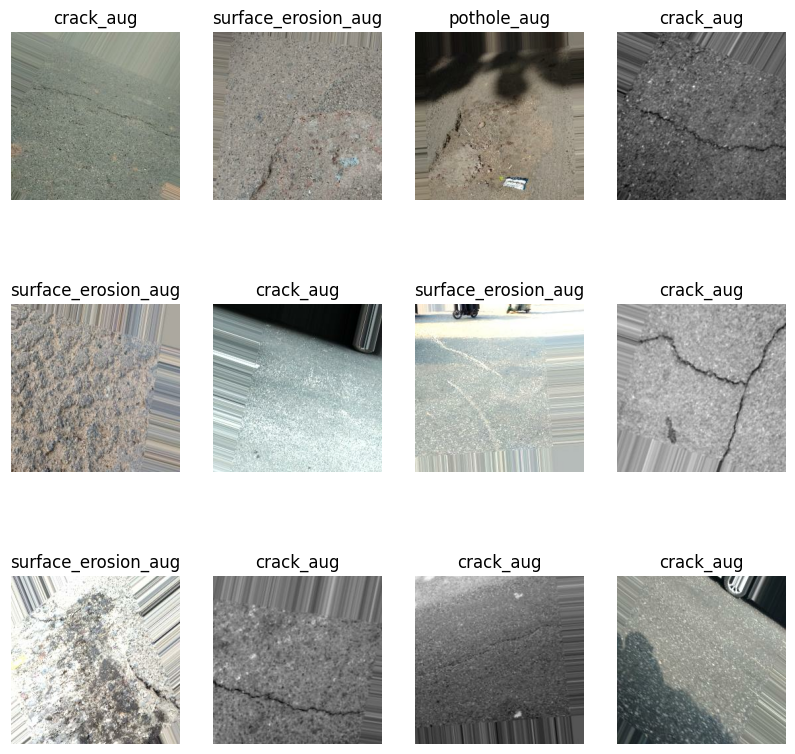

In [14]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [15]:

def partition_data(dataset, train_size=0.8, validation_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_size = int(total_size * train_size)
    validation_size = int(total_size * validation_size)
    test_size = int(total_size * test_size)

    # Split the data into training, validation, and test datasets
    train_data = dataset.take(train_size)
    remaining_data = dataset.skip(train_size)
    
    validation_data = remaining_data.take(validation_size)
    test_data = remaining_data.skip(validation_size)
    
    return train_data, validation_data, test_data


# Example usage:

# Assuming `dataset` is a tf.data.Dataset object
train_data, validation_data, test_data = partition_data(dataset)

# Check the lengths of each dataset
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")


Training data size: 254
Validation data size: 31
Test data size: 33


In [16]:
train_data, validation_data, test_data = partition_data(dataset)

In [17]:
len(train_data)
len(validation_data)
len(test_data)

33

In [18]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [21]:
# def build_mobilenet_model():
#     base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
#     base.trainable = False
#     model = models.Sequential([
#         resize_and_rescale,
#         #data_augmentation,
#         base,
#         layers.GlobalAveragePooling2D(),
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(N_CLASSES, activation='softmax')
#     ])
#     return model


def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    
    # Fine-tune the last few layers of the base model
    base.trainable = True
    fine_tune_at = 100  # Unfreeze the last 100 layers (you can adjust this)

    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False

    model = models.Sequential([
        resize_and_rescale,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model


In [22]:
model = build_mobilenet_model()

C:\Users\DCL\AppData\Local\Temp\ipykernel_12380\1101227505.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [24]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.7909 - loss: 0.5193 - val_accuracy: 0.3609 - val_loss: 13.1446
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.8976 - loss: 0.2660 - val_accuracy: 0.5736 - val_loss: 3.9884
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.9178 - loss: 0.2222 - val_accuracy: 0.4173 - val_loss: 9.1065
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.9399 - loss: 0.1579 - val_accuracy: 0.4889 - val_loss: 8.0878
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.9594 - loss: 0.1171 - val_accuracy: 0.4980 - val_loss: 5.8693
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.9698 - loss: 0.0930 - val_accuracy: 0.3014 - val_loss: 19.6972
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.9726 - loss: 0.0809 - val_accuracy: 0.4274 - val_loss: 15.6214
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.9782 - loss: 0.0658 - val_a

In [26]:
scores = model.evaluate(test_data)
scores

33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 674ms/step - accuracy: 0.8449 - loss: 1.6368


[1.8395240306854248, 0.834782600402832]

In [27]:
model.save("Trained Models/MOBILENET.h5")

In [28]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 254}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
history.history['accuracy']

[0.837598443031311,
 0.8966535329818726,
 0.9211367964744568,
 0.9373769760131836,
 0.9549704790115356,
 0.9692421555519104,
 0.9753937125205994,
 0.9744094610214233,
 0.9806840419769287,
 0.9819143414497375,
 0.9828985929489136,
 0.9874507784843445,
 0.9881889820098877,
 0.9896653294563293,
 0.9883120059967041,
 0.9885580539703369,
 0.985359251499176,
 0.9923720359802246,
 0.9899114370346069,
 0.9927411675453186,
 0.9929872155189514,
 0.9942175149917603,
 0.9896653294563293,
 0.9942175149917603,
 0.9942175149917603,
 0.993848443031311,
 0.9953247904777527,
 0.9892962574958801,
 0.991879940032959,
 0.9955708384513855,
 0.993848443031311,
 0.9878199100494385,
 0.9939714670181274,
 0.9958169460296631,
 0.9963090419769287,
 0.9979084730148315,
 0.9956939220428467,
 0.990895688533783,
 0.9942175149917603,
 0.9982775449752808,
 0.9952017664909363,
 0.9943405389785767,
 0.9947096705436707,
 0.9985235929489136,
 0.9969242215156555,
 0.9965550899505615,
 0.9947096705436707,
 0.9984005689620972

In [40]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [32]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

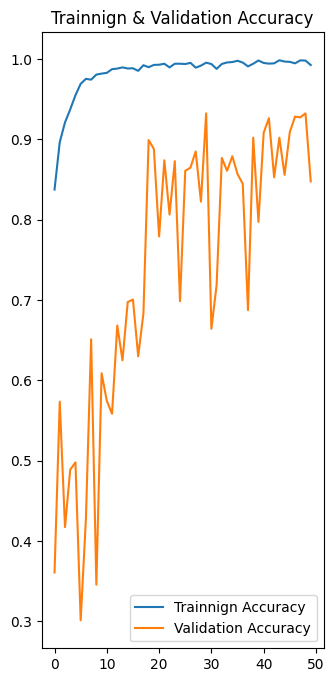

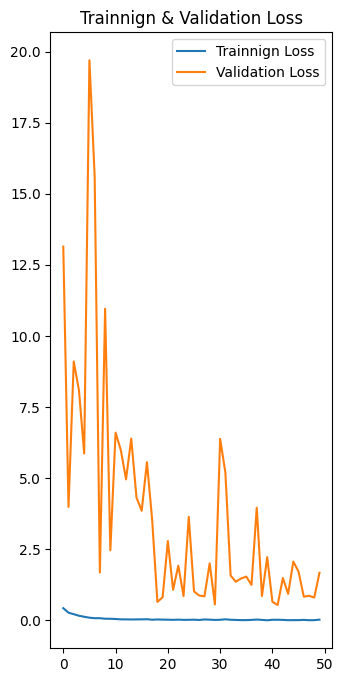

In [41]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [42]:
model.evaluate(test_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 662ms/step - accuracy: 0.8083 - loss: 2.1789


[1.8395237922668457, 0.834782600402832]

First image to predict
First image actual label:  surface_erosion_aug
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
Predicted Label:  surface_erosion_aug


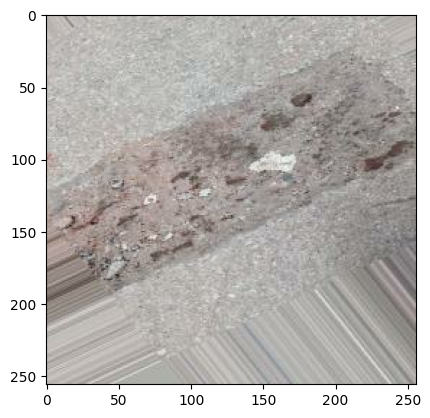

In [35]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->100.0 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->79.38999938964844 Light:-> Low light
Confidence:->100.0 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->100.0 Light:-> High light
Confidence:->98.08000183105469 Light:-> Normal lighting
Confidence:->100.0 Light:-> Low light


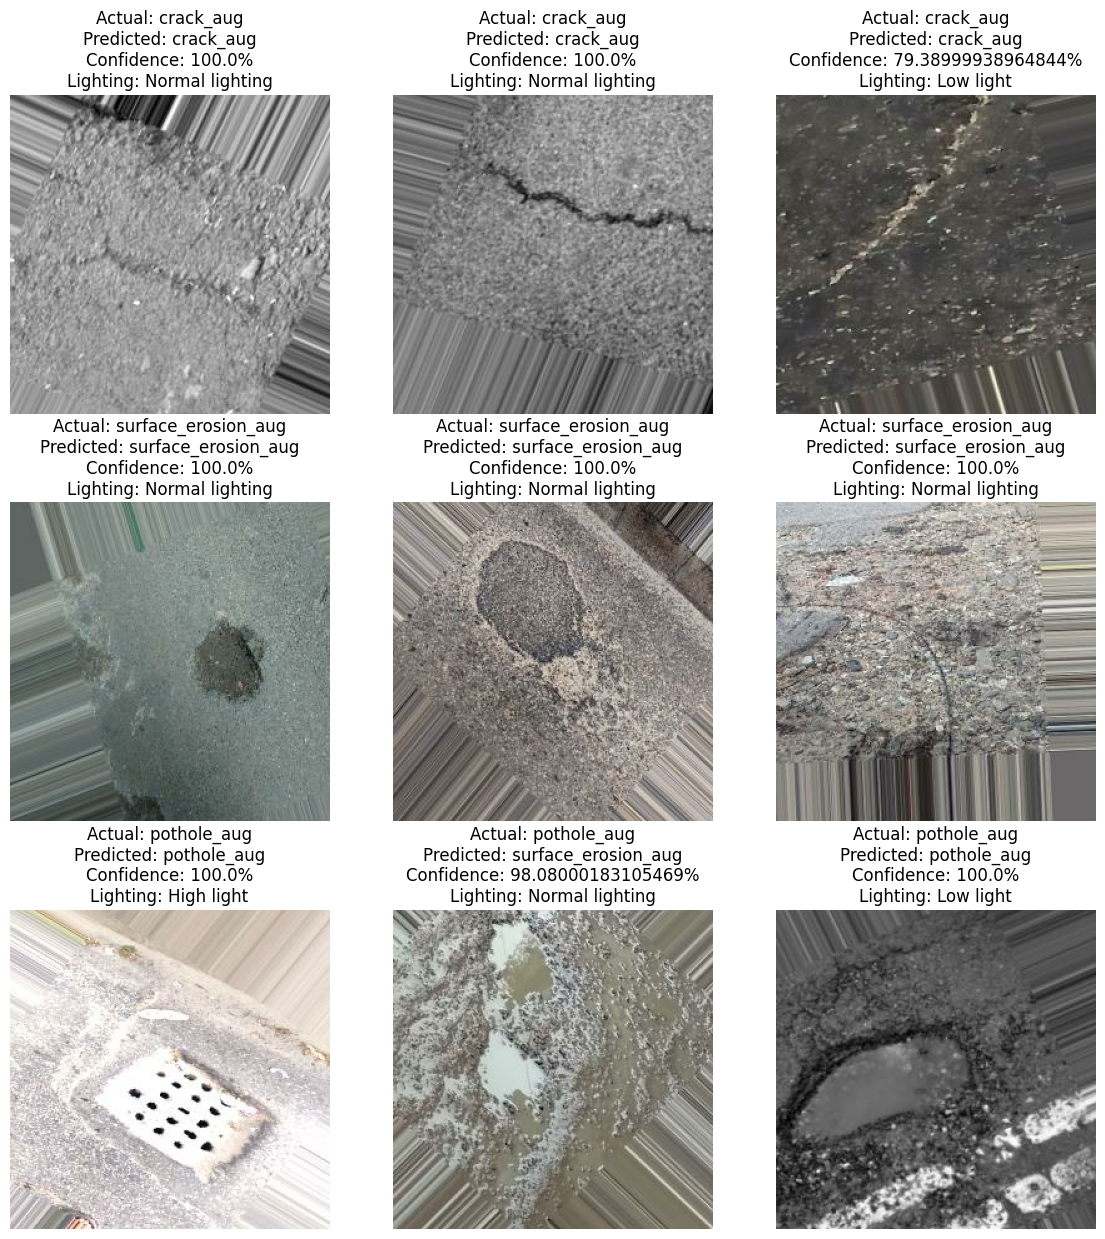

In [37]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [38]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: pothole_aug, Confidence: 100.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

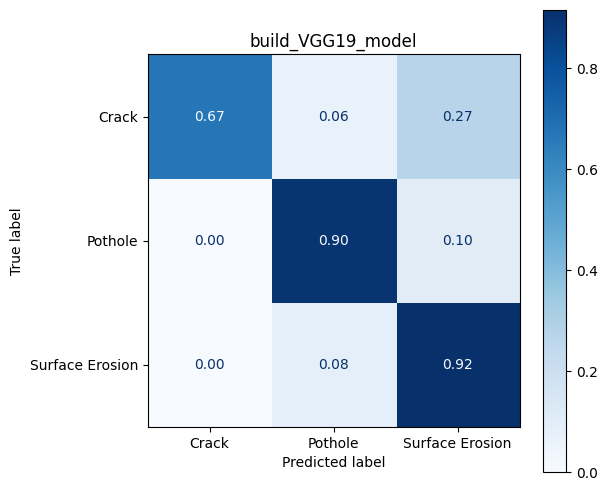

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Optional: define class names based on your dataset
class_names = ['Crack', 'Pothole', 'Surface Erosion']  # Update if you have different classes

# Step 1: Get true and predicted labels
y_true = []
y_pred = []

# Loop through test dataset
for images, labels in test_data:
    predictions = model.predict(images)
    
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Normalize the confusion matrix (row-wise normalization)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 4: Plot the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")  # 2 decimal places

# Step 5: Save and show the plot
plt.title("build_VGG19_model")
plt.savefig("confusion_matrix_mobilenet.png", dpi=300, bbox_inches='tight')
plt.show()
